In [1]:
#INSTALO PAQUETES

#!pip install pytrends
#!pip install gspread oauth2client

In [1]:
#IMPORTA LAS LIBRERÍAS

import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [11]:
#DEFINO FUNCIONES

def iter_pd(df):
    for val in df.columns:
        yield val
    for row in df.to_numpy():
        for val in row:
            if pd.isna(val):
                yield ""
            else:
                yield val
                
def pandas_to_sheets(pandas_df, sheet, clear=True):
    if clear:
        sheet.clear()
    (row, col) = pandas_df.shape
    cells = sheet.range("A1:{}".format(gspread.utils.rowcol_to_a1(row + 1, col)))
    for cell, val in zip(cells, iter_pd(pandas_df)):
        cell.value = val
    sheet.update_cells(cells)
    
def func_related(gsheet,wsheet,df_csv):
    df_csv.to_csv(r'C:\Users\Nahuel\Documents\Trends.csv', header=True)
    wks = client.open(gsheet).add_worksheet(wsheet, 10000, 6)
    df = pd.read_csv(r'C:\Users\Nahuel\Documents\Trends.csv')
    pandas_to_sheets(df,wks)
    
def func_anidada(py, kw, gsheet, wsheet):
    py.build_payload(kw,timeframe = 'today 12-m', geo = 'AR')
    
    try:
        rq = py.related_queries()
        rq_csv = rq[kw[0]]['top']
        func_related(gsheet,wsheet,rq_csv)
    except:
        print("No hay consultas relacionadas para ", wsheet)

def func_interest(py, kw, time, categ, gsheet, wsheet):
    py.build_payload(kw, timeframe = time, cat = categ, geo = 'AR')
    interest = py.interest_over_time()
    
    if interest.shape[0]!=0:
        interest = interest.drop('isPartial',axis=1)
    else:
        print('No hay resultado de búsqueda')
    
    func_related(gsheet,wsheet,interest)    

In [3]:
#DECLARO LA CUENTA DE SERVICIO Y EL NOMBRE DE LA HOJA DE GOOGLE

s = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('Jupyter y Sheet-c449b4243f48.json',s) #JSON DE CUENTA DE SERVICIO
client = gspread.authorize(creds)

nombre_gsheet = input('Nombre del Excel: ')
folder_id = "18Aovur_IdeqLwUG7u967LTsPENzwlD3F" #CARPETA DE GOOGLE DRIVE

sh = client.create(nombre_gsheet, folder_id)

pytrend = TrendReq()

Nombre del Excel: Clubes


In [4]:
#NO INGRESAR VALORES VACIOS Y MÁXIMO 5 PALABRAS A BUSCAR

count = 0

cantt = int(input('¿Cantidad de palabras a buscar? '))

if cantt > 5:
    print('Ingrese un número menor o igual a 5')
    exit()
else: 
    for i in range(cantt):
        count += 1
        if count<=cantt:
            globals()["key" + str(count)] = input('Ingrese la palabra a buscar: ')

category = int(input('Ingrese la categoría de la/s palabras a buscar: '))

¿Cantidad de palabras a buscar? 4
Ingrese la palabra a buscar: boca
Ingrese la palabra a buscar: river
Ingrese la palabra a buscar: san lorenzo
Ingrese la palabra a buscar: racing
Ingrese la categoría de la/s palabras a buscar: 20


In [5]:
#ARMO LAS VARIABLES A BUSCAR

if cantt == 1:
    kw_list = [globals()["key1"]]
elif cantt == 2:
    kw_list = [globals()["key1"],globals()["key2"]]
elif cantt == 3:
    kw_list = [globals()["key1"],globals()["key2"],globals()["key3"]]
elif cantt == 4:
    kw_list = [globals()["key1"],globals()["key2"],globals()["key3"],globals()["key4"]]
else:
    kw_list = [globals()["key1"],globals()["key2"],globals()["key3"],globals()["key4"],globals()["key5"]]

In [7]:
#ARMO LOS WORKSHEET POR LOS DISTINTOS PERÍODOS DE BÚSQUEDA

timeframe = ['today 12-m', 'today 3-m', 'today 1-m', 'now 7-d', 'now 1-d', 'now 4-H', 'now 1-H']
worksheet = ['Ultimo Año', 'Ultimos 3 Meses', 'Ultimo Mes', 'Ultima Semana', 'Ultimo Dia', 'Ultimas 4 Horas', 'Ultima Hora']

for dia in range(0,len(timeframe)):
    func_interest(pytrend, kw_list, timeframe[dia], category, nombre_gsheet, worksheet[dia])

sh1 = client.open(nombre_gsheet).sheet1
sh.del_worksheet(sh1)

{'spreadsheetId': '1-Nv2ovmevQ3K77q0qBr4Lv_a4UBFn-189y9avZ-I_Vo',
 'replies': [{}]}

Text(0, 0.5, 'Indice de Tendencia')

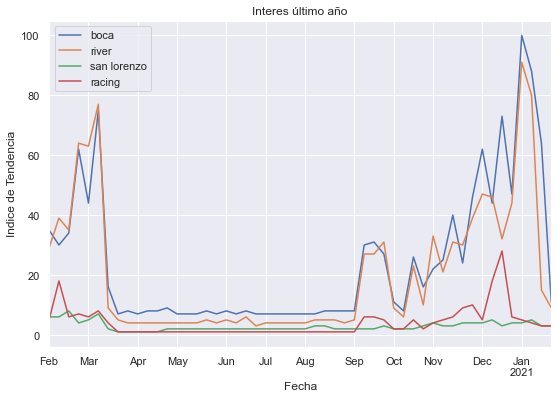

In [8]:
#GRÁFICO DE TENDENCIA

pytrend.build_payload(kw_list,timeframe = timeframe[0], geo = 'AR')
interest_12m = pytrend.interest_over_time()

sns.set(color_codes = True)
dx = interest_12m.plot.line(figsize=(9,6),title="Interes último año")
dx.set_xlabel('Fecha')
dx.set_ylabel('Indice de Tendencia')

In [9]:
#GENERACIÓN DE CONSULTAS RELACIONADAS

pytrend_q = TrendReq()
pytrend.build_payload(kw_list,timeframe = timeframe[0], cat = category, geo = 'AR')
related_queries = pytrend.related_queries()

if cantt == 1:
    related_queries_top1 = related_queries[kw_list[0]]['top']
    rq_top1a = related_queries_top1[:3]
    func_related(nombre_gsheet,'Palabra 1',related_queries_top1)
    
    try:
        kw_list_b = [rq_top1a.iloc[0,0],rq_top1a.iloc[1,0],rq_top1a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 1 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet, 'Palabra Anidada 1')
    except:
        print("No hay suficientes términos para anidar de Palabra 1")
    
elif cantt == 2: 
    related_queries_top1 = related_queries[kw_list[0]]['top']
    rq_top1a = related_queries_top1[:3]
    func_related(nombre_gsheet,'Palabra 1',related_queries_top1)
    
    try:
        kw_list_b = [rq_top1a.iloc[0,0],rq_top1a.iloc[1,0],rq_top1a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 1 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet, 'Palabra Anidada 1')
    except:
        print("No hay suficientes términos para anidar de Palabra 1")    
    
    related_queries_top2 = related_queries[kw_list[1]]['top']
    rq_top2a = related_queries_top2[:3]
    func_related(nombre_gsheet,'Palabra 2',related_queries_top2)
    
    try:
        kw_list_b = [rq_top2a.iloc[0,0],rq_top2a.iloc[1,0],rq_top2a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 2 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 2')
    except:
        print("No hay suficientes términos para anidar de Palabra 2")

elif cantt == 3:
    related_queries_top1 = related_queries[kw_list[0]]['top']
    rq_top1a = related_queries_top1[:3]
    func_related(nombre_gsheet,'Palabra 1',related_queries_top1)
    
    try:
        kw_list_b = [rq_top1a.iloc[0,0],rq_top1a.iloc[1,0],rq_top1a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 1 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet, 'Palabra Anidada 1')
    except:
        print("No hay suficientes términos para anidar de Palabra 1")    
    
    related_queries_top2 = related_queries[kw_list[1]]['top']
    rq_top2a = related_queries_top2[:3]
    func_related(nombre_gsheet,'Palabra 2',related_queries_top2)
    
    try:
        kw_list_b = [rq_top2a.iloc[0,0],rq_top2a.iloc[1,0],rq_top2a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 2 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 2')
    except:
        print("No hay suficientes términos para anidar de Palabra 2")
    
    related_queries_top3 = related_queries[kw_list[2]]['top']
    rq_top3a = related_queries_top3[:3]
    func_related(nombre_gsheet,'Palabra 3',related_queries_top3)
    
    try:
        kw_list_b = [rq_top3a.iloc[0,0],rq_top3a.iloc[1,0],rq_top3a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 3
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 3')    
    except:
        print("No hay suficientes términos para anidar de Palabra 3")

elif cantt == 4:
    related_queries_top1 = related_queries[kw_list[0]]['top']
    rq_top1a = related_queries_top1[:3]
    func_related(nombre_gsheet,'Palabra 1',related_queries_top1)
    
    try:
        kw_list_b = [rq_top1a.iloc[0,0],rq_top1a.iloc[1,0],rq_top1a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 1 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet, 'Palabra Anidada 1')
    except:
        print("No hay suficientes términos para anidar de Palabra 1")    
    
    related_queries_top2 = related_queries[kw_list[1]]['top']
    rq_top2a = related_queries_top2[:3]
    func_related(nombre_gsheet,'Palabra 2',related_queries_top2)
    
    try:
        kw_list_b = [rq_top2a.iloc[0,0],rq_top2a.iloc[1,0],rq_top2a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 2 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 2')
    except:
        print("No hay suficientes términos para anidar de Palabra 2")
    
    related_queries_top3 = related_queries[kw_list[2]]['top']
    rq_top3a = related_queries_top3[:3]
    func_related(nombre_gsheet,'Palabra 3',related_queries_top3)
    
    try:
        kw_list_b = [rq_top3a.iloc[0,0],rq_top3a.iloc[1,0],rq_top3a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 3
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 3')    
    except:
        print("No hay suficientes términos para anidar de Palabra 3")
    
    related_queries_top4 = related_queries[kw_list[3]]['top']
    rq_top4a = related_queries_top4[:3]
    func_related(nombre_gsheet,'Palabra 4',related_queries_top4)
    
    try:
        kw_list_b = [rq_top4a.iloc[0,0],rq_top4a.iloc[1,0],rq_top4a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 4
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 4')    
    except:
        print("No hay suficientes términos para anidar de Palabra 4")
    
else:
    related_queries_top1 = related_queries[kw_list[0]]['top']
    rq_top1a = related_queries_top1[:3]
    func_related(nombre_gsheet,'Palabra 1',related_queries_top1)
    
    try:
        kw_list_b = [rq_top1a.iloc[0,0],rq_top1a.iloc[1,0],rq_top1a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 1 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet, 'Palabra Anidada 1')
    except:
        print("No hay suficientes términos para anidar de Palabra 1")    
    
    related_queries_top2 = related_queries[kw_list[1]]['top']
    rq_top2a = related_queries_top2[:3]
    func_related(nombre_gsheet,'Palabra 2',related_queries_top2)
    
    try:
        kw_list_b = [rq_top2a.iloc[0,0],rq_top2a.iloc[1,0],rq_top2a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 2 
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 2')
    except:
        print("No hay suficientes términos para anidar de Palabra 2")
    
    related_queries_top3 = related_queries[kw_list[2]]['top']
    rq_top3a = related_queries_top3[:3]
    func_related(nombre_gsheet,'Palabra 3',related_queries_top3)
    
    try:
        kw_list_b = [rq_top3a.iloc[0,0],rq_top3a.iloc[1,0],rq_top3a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 3
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 3')    
    except:
        print("No hay suficientes términos para anidar de Palabra 3")
    
    related_queries_top4 = related_queries[kw_list[3]]['top']
    rq_top4a = related_queries_top4[:3]
    func_related(nombre_gsheet,'Palabra 4',related_queries_top4)
    
    try:
        kw_list_b = [rq_top4a.iloc[0,0],rq_top4a.iloc[1,0],rq_top4a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 4
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 4')    
    except:
        print("No hay suficientes términos para anidar de Palabra 4")
    
    related_queries_top5 = related_queries[kw_list[4]]['top']
    rq_top5a = related_queries_top5[:3]
    func_related(nombre_gsheet,'Palabra 5',related_queries_top5)
    
    try:
        kw_list_b = [rq_top5a.iloc[0,0],rq_top5a.iloc[1,0],rq_top5a.iloc[2,0]]
        #REALIZO BUSQUEDA DE CONSULTAS ANIDADAS Y GENERO GSHEET 5
        func_anidada(pytrend_q, kw_list_b, nombre_gsheet,'Palabra Anidada 5')
    except:
        print("No hay suficientes términos para anidar de Palabra 5")

In [10]:
#GENERO EL WORKSHEET DE INTERÉS POR REGION (PROVINCIAS)

pytrend.build_payload(kw_list,timeframe = timeframe[0], cat = category, geo = 'AR')
interest_by_region = pytrend.interest_by_region()
func_related(nombre_gsheet,"Interes Región",interest_by_region)

In [13]:
#INTERES DE BÚSQUEDA HISTÓRICO

pytrend_h = TrendReq(timeout = (10,25))

year_start = int(input('Ingrese el año de inicio: '))
month_start = int(input('Ingrese el mes de inicio: '))
day_start = int(input('Ingrese el día de inicio: '))
hour_start = int(input('Ingrese la hora de inicio: '))
year_end = int(input('Ingrese el año de finalización: '))
month_end = int(input('Ingrese el mes de finalización: '))
day_end = int(input('Ingrese el día de finalización: '))
hour_end = int(input('Ingrese la hora de finalización: '))

interest_historical = pytrend_h.get_historical_interest(kw_list, year_start, month_start, day_start,
                                                      hour_start, year_end, month_end, day_end, hour_end, 
                                                      cat = category, geo = 'AR')
if interest_historical.shape[0]!=0:
    interest_historical = interest_historical.drop('isPartial',axis=1)
else:
    print('No hay resultado de búsqueda')
    
interest_historical.to_csv(r'C:\Users\Nahuel\Documents\Trends.csv', header=True)
wks_hist = client.open(nombre_gsheet).add_worksheet("Histórico",500000, 6)
df_hist = pd.read_csv(r'C:\Users\Nahuel\Documents\Trends.csv')
pandas_to_sheets(df_hist,wks_hist)   

Ingrese el año de inicio: 2020
Ingrese el mes de inicio: 1
Ingrese el día de inicio: 1
Ingrese la hora de inicio: 0
Ingrese el año de finalización: 2020
Ingrese el mes de finalización: 12
Ingrese el día de finalización: 31
Ingrese la hora de finalización: 23


In [12]:
exit()